# ADT Tutorial
This tutorial will walk through the steps to fetch groundtruth data for an ADT sequence and visualize all the together with the Aria raw sensor data. All data being visualized includes:
* Raw camera data
* Object 2d bounding box
* Object 6DoF pose and 3d bounding box 
* Segmentation image 
* Depth image 
* Synthetic image
* Eye gaze 
* Human skeleton

In [1]:
import numpy as np
import os
import sys
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.graph_objects as go
from math import tan
import random

from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core import calibration
from projectaria_tools.projects.adt import (
    AriaDigitalTwinDataProvider,
    AriaDigitalTwinSkeletonProvider,
    AriaDigitalTwinDataPathsProvider,
    bbox3d_to_line_coordinates,
    bbox2d_to_image_coordinates,
    utils as adt_utils,
)

In [2]:
import projectaria_tools as pat, sys
from importlib.metadata import version, PackageNotFoundError
print("pat file:", getattr(pat, "__file__", "NA"))
try:
    print("pat dist version:", version("projectaria-tools"))
except PackageNotFoundError:
    print("pat dist version: not in dist metadata")
print("python:", sys.version)

pat file: /home/liumu/miniconda3/envs/aria_env/lib/python3.10/site-packages/projectaria_tools/__init__.py
pat dist version: 1.6.0
python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]


### Download the example sequence

The following code cell will directly download the [ADT sample dataset](https://www.projectaria.com/async/sample/download/?bucket=adt&filename=aria_digital_twin_test_data.zip).  

In [ ]:
adt_sample_path = "../../../projectaria_tools_adt_data/adt_sample_data"

data_sequence_url = "https://www.projectaria.com/async/sample/download/?bucket=adt&filename=aria_digital_twin_test_data_v2.zip"
command_list = [
    f"mkdir -p {adt_sample_path}",
    # Download sample data
    f'curl -o {adt_sample_path}/adt_sample_data.zip -C - -O -L "{data_sequence_url}"',
    # Unzip the sample data
    f"unzip -o {adt_sample_path}/adt_sample_data.zip -d {adt_sample_path}"
]
sequence_path = f"{adt_sample_path}/Apartment_release_golden_skeleton_seq100_10s_sample_M1292"

for command in command_list:
    subprocess.run(command, shell=True, check=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  638M  100  638M    0     0  70.4M      0  0:00:09  0:00:09 --:--:-- 81.1M


Archive:  ../projectaria_tools_adt_data/adt_sample_data/adt_sample_data.zip
   creating: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/
  inflating: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/video.vrs  
   creating: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/mps/
   creating: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/mps/slam/
  inflating: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/mps/slam/closed_loop_trajectory.csv  
  inflating: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/mps/slam/open_loop_trajectory.csv  
  inflating: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/mps

### Get data files for the target sequence

To help load all files associated with a sequence, we have an AriaDigitalTwinDataPathsProvider which takes in a sequence path and fills in all individual filepaths. You can then feed that directly to the data loader, or you can replace these paths with your custom data, or even remove filepaths to avoid loading that data.

In [4]:
paths_provider = AriaDigitalTwinDataPathsProvider(sequence_path)
data_paths = paths_provider.get_datapaths()
print(data_paths)

--sequenceName: Apartment_release_golden_skeleton_seq100_10s_sample_M1292
--ariaVrsFilePath: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/video.vrs
--ariaTrajectoryFilePath: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/aria_trajectory.csv
--objectTrajectoriesFilePath: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/scene_objects.csv
--objectBoundingBox3dFilePath: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/3d_bounding_box.csv
--segmentationsFilePath: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/segmentations.vrs
--depthImagesFilePath: ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/depth_images.vrs
--syntheticVideoFilePath: ../projectaria_tool

[MpsDataPathsProvider][WARNING]: Hand tracking folder (../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/mps/hand_tracking) does not exist in MPS root folder, not loading hand tracking results.


### Load data
**Expected warnings**: The AriaDigitalTwinDataProvider loads 4 VRS files:

    1. Raw Aria recording (stream ids: 211-1, 214-1, 247-1, 1201-1/2, 1202-1/2, 1203-1)
    2. Synthetic twin recording (stream ids: 214-1, 1201-1/2, 1202-2)
    3. Segmentation images (stream ids: 400-1/2/3)
    4. Depth images (stream ids: 345-1/2/3)

VRS files 1 and 2 have their own calibrations embeded into the VRS file at record time. Since VRS files 2 and 3 are annotations of the data in VRS 1, these do not contain a calibration to avoid duplicating the existing calibration in the raw data. For manipulating image data from VRS files 2 and 3, you should use the calibration from VRS file 1. For a full list of stream ids and their descriptions, see [StreamId.h](https://github.com/facebookresearch/vrs/blob/main/vrs/StreamId.h)

In [5]:
print("loading ground truth data...")
gt_provider = AriaDigitalTwinDataProvider(data_paths)
print("done loading ground truth data")

loading ground truth data...
done loading ground truth data
Loaded #closed loop trajectory poses records: 300
Loaded #EyeGazes: 300


[ProgressLogger][INFO]: 2025-08-19 14:06:11: Opening ../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/video.vrs...
[MultiRecordFileReader][DEBUG]: Opened file '../projectaria_tools_adt_data/adt_sample_data/Apartment_release_golden_skeleton_seq100_10s_sample_M1292/video.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Timecode stream found: 285-2
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO]: streamId 1202-2/imu-left activated
[VrsDataProvider][INFO]: streamId 1203-1/mag0 activated
[AriaDigitalTwinDataProvider]

### Get Info of Instances in the sequence
In ADT, an instance can be either an object or a person (skeleton). Each instance has a unique id that is used for indexing the 3D bboxes, 2D bboxes and the value of a segmentation pixel (segmentation images contain an instance id in each pixel of the image). By using instance id, you can check the instance information in the instance info

In [6]:
instances_ids = gt_provider.get_instance_ids()
print("there are {} object in this sequence".format(len(instances_ids)))
# load a random instance information
random_id = int(len(instances_ids) / 2)
print('\n' +  '\033[1m' + 'Instance info from randomly selected instance: ' + '\033[0m')
print(gt_provider.get_instance_info_by_id(instances_ids[random_id]))

there are 350 object in this sequence

Instance info from randomly selected instance: 
instance id: 8831369073541652
instance name: CloudNightLight_1
prototype name: CloudNightLight
category: light
category uid: 7
instance type: Object
motion type: Static
rigidity type: Rigid
rotational symmetry: isAnnotated = false,  axes = []
canonical pose: up_vector = [0, 1, 0], front_vector = [0, 0, 1]
associated aria (only for human type): 



### Select a target object for the rest of tutorial
Some example objects observed in the example sequence and select one of them, e.g.: 

* 4404207983027294: ChoppingBoard
* 4587554268035732: Mug_2
* 4233561046743320: FacebookPortal
* 7379153972126671: WhiteVase

In [7]:
target_obj_id = 7379153972126671


print('\n' +  '\033[1m' + 'The object you have chosen is: ' + '\033[0m')
print(gt_provider.get_instance_info_by_id(target_obj_id))


The object you have chosen is: 
instance id: 7379153972126671
instance name: WhiteVase
prototype name: WhiteVase
category: vase
category uid: 228
instance type: Object
motion type: Dynamic
rigidity type: Rigid
rotational symmetry: isAnnotated = true,  axes = []
canonical pose: up_vector = [0, 1, 0], front_vector = [0, 0, 1]
associated aria (only for human type): 



### Get raw Aria sensor frame
**stream id**: ID of the camera you want to view. Aria has 3 cameras, the IDs of each camera are as follows: 214-1 for RGB, 1201-1 for SLAM LEFT, 1201-2 for SLAM RIGHT

There are 300 frames
loading image with timestamp:  87556170021637  ns
image_time - query_time:  0  ns


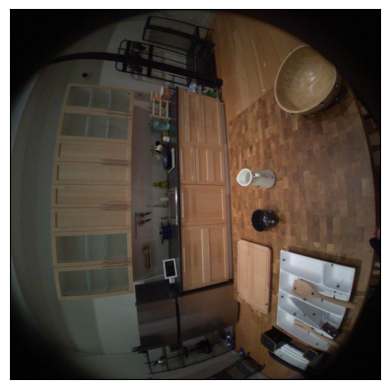

In [8]:
stream_id = StreamId("214-1")
img_timestamps_ns = gt_provider.get_aria_device_capture_timestamps_ns(stream_id)
print("There are {} frames".format(len(img_timestamps_ns)))

# choose the frame in the middle of the sequence
select_timestamps_ns = img_timestamps_ns[int(len(img_timestamps_ns) / 2)]

# fetch the raw data
print("loading image with timestamp: ", select_timestamps_ns, " ns")
image_with_dt = gt_provider.get_aria_image_by_timestamp_ns(select_timestamps_ns, stream_id)

# check image is valid. It's always possible that the data retrieval fails, therefore all 
# returned data not only contains dt, but also contains an is_valid() function, or returns
# an optional variable.
assert image_with_dt.is_valid(), "Image not valid"

# since all image data and some GT data is discrete, each time we query discrete data
# from the data providers we return an object with dt. Dt is the difference between 
# returned data time and the query time. For this case, since we are querying for images 
# using the real image times we already fetched, dt should be zero. Note that if we iterated 
# through GT timestamps, they may not correspond to the exact same time points as the camera
# data. We align GT data to SLAM camera timestamps, so if querying RGB images using GT 
# timestamps, dt will not be zero
print("image_time - query_time: ", image_with_dt.dt_ns(), " ns")

# convert image to numpy array
image = image_with_dt.data().to_numpy_array()

# pad SLAM camera gray-scale image to 3 channel for color visualization
image = np.repeat(image[..., np.newaxis], 3, axis=2) if len(image.shape) < 3 else image
plt.imshow(image); plt.xticks([]);plt.yticks([]);

### Get and draw 2D bounding box on Aria sensor frame

groundtruth_time - query_time =  89063  ns
[xmin, xmax, ymin, ymax]:  [ 864. 1010.  603.  679.]

selected object information: 
instance id: 7379153972126671
instance name: WhiteVase
prototype name: WhiteVase
category: vase
category uid: 228
instance type: Object
motion type: Dynamic
rigidity type: Rigid
rotational symmetry: isAnnotated = true,  axes = []
canonical pose: up_vector = [0, 1, 0], front_vector = [0, 0, 1]
associated aria (only for human type): 



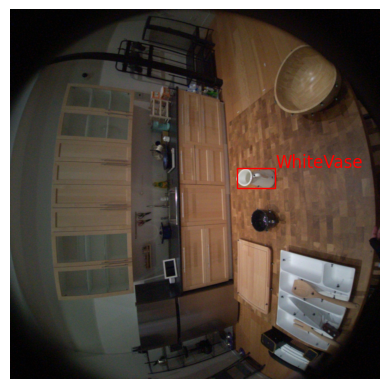

In [9]:
# get all observed 2D bboxes in the selected frame
bbox2d_with_dt = gt_provider.get_object_2d_boundingboxes_by_timestamp_ns(select_timestamps_ns, stream_id)

# check if the result is valid
if not bbox2d_with_dt.is_valid():
    print("2D bounding box is not available")
print("groundtruth_time - query_time = ", bbox2d_with_dt.dt_ns(), " ns")
bbox2d_all_objects = bbox2d_with_dt.data()

# get bbox of the target object
bbox2d_target_obj = bbox2d_all_objects[target_obj_id].box_range
print("[xmin, xmax, ymin, ymax]: ", bbox2d_target_obj)

# setup plot
rect = patches.Rectangle((bbox2d_target_obj[0], bbox2d_target_obj[2]),
                         bbox2d_target_obj[1] - bbox2d_target_obj[0],
                         bbox2d_target_obj[3] - bbox2d_target_obj[2],
                         linewidth=1, edgecolor='r', facecolor="none")

fig, ax = plt.subplots()
ax.imshow(image);
ax.add_patch(rect)
ax.axis("off")

# draw and output object information
target_obj_info = None
if gt_provider.has_instance_id(target_obj_id):
    target_obj_info = gt_provider.get_instance_info_by_id(target_obj_id)
    plt.text(bbox2d_target_obj[1], bbox2d_target_obj[2], target_obj_info.name, c="r", fontsize=12)
    print('\n' + '\033[1m' + 'selected object information: ' + '\033[0m')
    print(str(target_obj_info))

plt.show();


### Get and draw 3D bounding box on Aria sensor frame

3D bounding box dt: groundtruth_time - query_time =  89063  ns
AABB [xmin, xmax, ymin, ymax, zmin, zmax]:  [-4.96260077e-02  4.97610010e-02 -8.15093517e-05  1.64722040e-01
 -6.83648661e-02  6.55332580e-02]
Aria pose dt: groundtruth_time - query_time =  88363  ns


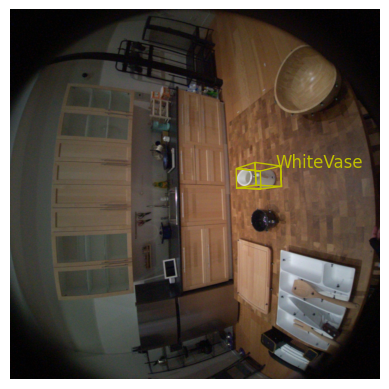

In [10]:
# get object poses and Aria poses of the selected frame
bbox3d_with_dt = gt_provider.get_object_3d_boundingboxes_by_timestamp_ns(select_timestamps_ns)
if not bbox3d_with_dt.is_valid():
    print("3D bounding box is not available")
bbox3d = bbox3d_with_dt.data()[target_obj_id]
print("3D bounding box dt: groundtruth_time - query_time = ", bbox3d_with_dt.dt_ns(), " ns")
print("AABB [xmin, xmax, ymin, ymax, zmin, zmax]: ", bbox3d.aabb)

# get the Aria pose
aria3dpose_with_dt = gt_provider.get_aria_3d_pose_by_timestamp_ns(select_timestamps_ns)
if not aria3dpose_with_dt.is_valid():
    print("aria 3d pose is not available")
aria3dpose = aria3dpose_with_dt.data()
print("Aria pose dt: groundtruth_time - query_time = ", aria3dpose_with_dt.dt_ns(), " ns")

# now to project 3D bbox to Aria camera
# get 6DoF object pose with respect to the target camera
transform_cam_device = gt_provider.get_aria_transform_device_camera(stream_id).inverse()
transform_cam_scene = transform_cam_device.to_matrix() @ aria3dpose.transform_scene_device.inverse().to_matrix()
transform_cam_obj = transform_cam_scene @ bbox3d.transform_scene_object.to_matrix()

# get projection function
cam_calibration = gt_provider.get_aria_camera_calibration(stream_id)
assert cam_calibration is not None, "no camera calibration"

# get projected bbox
reprojected_bbox = adt_utils.project_3d_bbox_to_image(bbox3d.aabb, transform_cam_obj, cam_calibration)
if reprojected_bbox:
    # plot
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis("off")
    ax.add_patch(plt.Polygon(reprojected_bbox, linewidth=1, edgecolor='y', facecolor="none"))
    if target_obj_info:
        plt.text(bbox2d_target_obj[1], bbox2d_target_obj[2], target_obj_info.name, c="y", fontsize=12)
    plt.show()
else:
    print('\033[1m' + '\033[91m' + 'Try another object!' + '\033[0m')

### Get and draw segmentation 

groundtruth_time - query_time =  88362 ns
1408


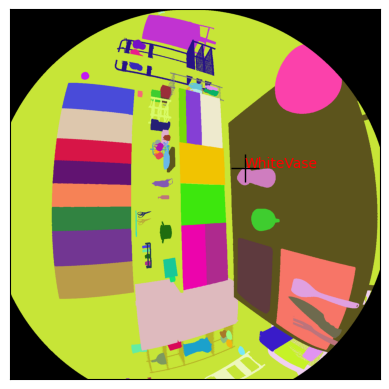

In [11]:
segmentation_with_dt = gt_provider.get_segmentation_image_by_timestamp_ns(select_timestamps_ns, stream_id)

# check if the results is valid
assert segmentation_with_dt.is_valid(), "segmentation not valid for input timestamp!"
print("groundtruth_time - query_time = ", segmentation_with_dt.dt_ns(), "ns")
segmentation_for_viz = segmentation_with_dt.data().get_visualizable().to_numpy_array()
plt.imshow(segmentation_for_viz)

# Access segmentation raw data
print(segmentation_with_dt.data().get_width())
segmentation_data = segmentation_with_dt.data().to_numpy_array()
itemindex = np.where(segmentation_data == target_obj_id)

row = itemindex[0][0]
col = itemindex[1][0]

plt.plot(col, row, '+', c="black", mew=1, ms=20); plt.xticks([]); plt.yticks([]);

if target_obj_info:
    plt.text(col, row, target_obj_info.name, c="red", bbox=dict(fill=False, edgecolor='none', linewidth=2))

### Get and draw depth map 

groundtruth_time - query_time =  88362 ns


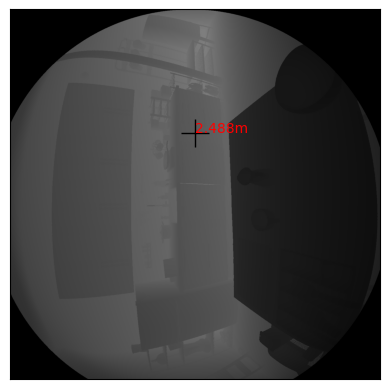

In [12]:
depth_with_dt = gt_provider.get_depth_image_by_timestamp_ns(select_timestamps_ns, stream_id)

# check if the result is valid
if not depth_with_dt.is_valid():
    print("depth map not valid for input timestamp!")
print("groundtruth_time - query_time = ", depth_with_dt.dt_ns(), "ns")

# draw image
depth_image = depth_with_dt.data()
depth_for_vis = depth_with_dt.data().get_visualizable().to_numpy_array()
depth_for_vis = np.repeat(depth_for_vis[..., np.newaxis], 3, axis=2)
plt.imshow(depth_for_vis)

# Access depth raw data
row = int(depth_image.get_height() / 3) 
col = int(depth_image.get_width() / 2)
depth_mm = depth_image.at(col, row)
plt.plot(col, row, '+', c="black", mew=1, ms=20); plt.xticks([]); plt.yticks([]); 
plt.text(col, row, str(depth_mm / 1e3) + "m", c = "red", bbox=dict(fill=False, edgecolor='none', linewidth=2));

### Get and draw synthetic image 

groundtruth_time - query_time =  888363 ns


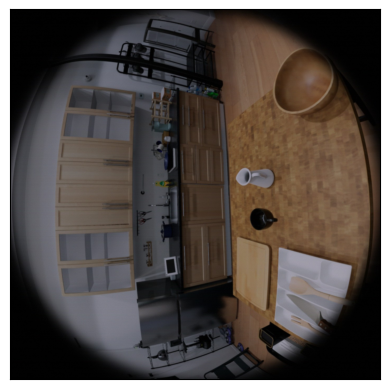

In [13]:
synthetic_with_dt = gt_provider.get_synthetic_image_by_timestamp_ns(int(select_timestamps_ns), stream_id)
# check if the result is valid
# TODO: change back to assert when all datasets have synthetic
# assert synthetic_with_dt.is_valid(), "synthetic image not valid for input timestamp!"

if synthetic_with_dt.is_valid():
    print("groundtruth_time - query_time = ", synthetic_with_dt.dt_ns(), "ns")
    synthetic_image = synthetic_with_dt.data().to_numpy_array()
    synthetic_image = np.repeat(synthetic_image[..., np.newaxis], 3, axis=2) if len(synthetic_image.shape) < 3 else synthetic_image
    plt.imshow(synthetic_image); plt.xticks([]); plt.yticks([]);    
else:
    print("synthetic image not valid for input timestamp!")   

### Get and draw eye gaze

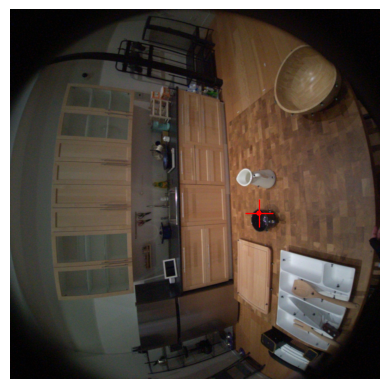

In [14]:
eye_gaze_with_dt = gt_provider.get_eyegaze_by_timestamp_ns(select_timestamps_ns)
assert eye_gaze_with_dt.is_valid(), "Eye gaze not available"

# Project the gaze center in CPF frame into camera sensor plane, with multiplication performed in homogenous coordinates
eye_gaze = eye_gaze_with_dt.data()
gaze_center_in_cpf = np.array([tan(eye_gaze.yaw), tan(eye_gaze.pitch), 1.0], dtype = np.float64) * eye_gaze.depth
transform_cpf_sensor = gt_provider.raw_data_provider_ptr().get_device_calibration().get_transform_cpf_sensor(cam_calibration.get_label())
gaze_center_in_camera = transform_cpf_sensor.inverse().to_matrix() @ np.hstack((gaze_center_in_cpf, 1)).T
gaze_center_in_camera = gaze_center_in_camera[:3] / gaze_center_in_camera[3:]
gaze_center_in_pixels = cam_calibration.project(gaze_center_in_camera)

# Draw a solid circle plus a cross at the projected gaze center location
if gaze_center_in_pixels is not None:
    circle = patches.Circle(gaze_center_in_pixels.flatten(), radius = 10.0, facecolor="red")
    fig, ax = plt.subplots()
    ax.imshow(image);
    ax.add_patch(circle)
    ax.axis('off')
    
    # Plot the cross
    u, v = gaze_center_in_pixels.flatten()
    plt.plot(u, v, '+', c="red", mew=1, ms=20); plt.xticks([]); plt.yticks([]); 
    plt.show()
else:
    print(f"Eye gaze center projected to {gaze_center_in_pixels}, which is out of camera sensor plane.")

### Draw 3D Bounding Boxes in 3D for all objects

In [15]:
# get object 3d bounding box
bbox3d_with_dt = gt_provider.get_object_3d_boundingboxes_by_timestamp_ns(select_timestamps_ns)
assert bbox3d_with_dt.is_valid(), "3D bounding box is not available"
bboxes3d = bbox3d_with_dt.data()
print("groundtruth_time - query_time = ", bbox3d_with_dt.dt_ns(), "ns")

# transform AABB to OBB and visualize
traces = []
obbs = []
for obj_id in bboxes3d:
    bbox3d = bboxes3d[obj_id]
    aabb = bbox3d.aabb
    aabb_coords = bbox3d_to_line_coordinates(aabb)
    obb = np.zeros(shape=(len(aabb_coords), 3))
    for i in range(0, len(aabb_coords)):
        aabb_pt = aabb_coords[i]
        aabb_pt_homo = np.append(aabb_pt, [1])
        obb_pt = (bbox3d.transform_scene_object.to_matrix()@aabb_pt_homo)[0:3]
        obb[i] = obb_pt
    obbs.append(obb) 
    obj_name = str(obj_id)
    if gt_provider.has_instance_id(obj_id):
        obj_name = gt_provider.get_instance_info_by_id(obj_id).name
    traces.append(go.Scatter3d(
        x=obb[:, 0],
        y=obb[:, 1],
        z=obb[:, 2],
        name=obj_name,
        mode="lines",
        line=go.scatter3d.Line(width=5),
    ))

layout = go.Layout(scene=dict(dragmode='orbit', aspectmode='data', xaxis_visible=False, yaxis_visible=False,zaxis_visible=False))
figure = go.Figure(data=traces, layout=layout)
figure.show()

groundtruth_time - query_time =  89063 ns


### Get and draw skeleton in 3D

In [16]:
# get all available skeletons in a sequence
skeleton_ids = gt_provider.get_skeleton_ids()
skeleton_info = gt_provider.get_instance_info_by_id(skeleton_ids[0])
print("skeleton ", skeleton_info.name, " wears ", skeleton_info.associated_device_serial)

skeleton_with_dt = gt_provider.get_skeleton_by_timestamp_ns(select_timestamps_ns, skeleton_ids[0] )
assert skeleton_with_dt.is_valid(), "skeleton is not valid"
print("groundtruth_time - query_time = ", skeleton_with_dt.dt_ns(), "ns")
skeleton = skeleton_with_dt.data()
joints = skeleton.joints

traces = []
# draw skeleton
joint_labels = AriaDigitalTwinSkeletonProvider.get_joint_labels()
joint_connections = AriaDigitalTwinSkeletonProvider.get_joint_connections()
for i in range(0, len(joint_connections)):
    joint_1 = joints[joint_connections[i][0]]
    joint_2 = joints[joint_connections[i][1]]
    traces.append(go.Scatter3d(
        x=[joint_1[0], joint_2[0]],
        y=[joint_1[1], joint_2[1]],
        z=[joint_1[2], joint_2[2]],
        name=joint_labels[joint_connections[i][0]],
        mode="lines",
        line=go.scatter3d.Line(width=5),
    ))

# draw objects together with skeleton
for obb in obbs:
    # skip too high objects to focus on skeleton
    if max(obb[:, 1]) > 3:
        continue
    traces.append(go.Scatter3d(
        x=obb[:, 0],
        y=obb[:, 1],
        z=obb[:, 2],
        mode="lines",
        line=dict(color=['rgba(128, 128, 128, 0.6)']*len(obb), width=5),
        showlegend=False
    ))
layout = go.Layout(scene=dict(dragmode='orbit', aspectmode='data', xaxis_visible=False, yaxis_visible=False,zaxis_visible=False))
figure = go.Figure(data=traces, layout=layout)
figure.show()

skeleton  Skeleton_T  wears  1WM103600M1292
groundtruth_time - query_time =  -3171993 ns


### Rectify ADT data
Sometimes you may want to rectify ADT data coming from Aria's fisheye cameras. The instruction below shows how to rectify a raw Aria sensor image, the 2D bounding box and segmentation. The same step can be applied to 3D bounding boxes, depth images and synthetic images easily. 

<Figure size 640x480 with 0 Axes>

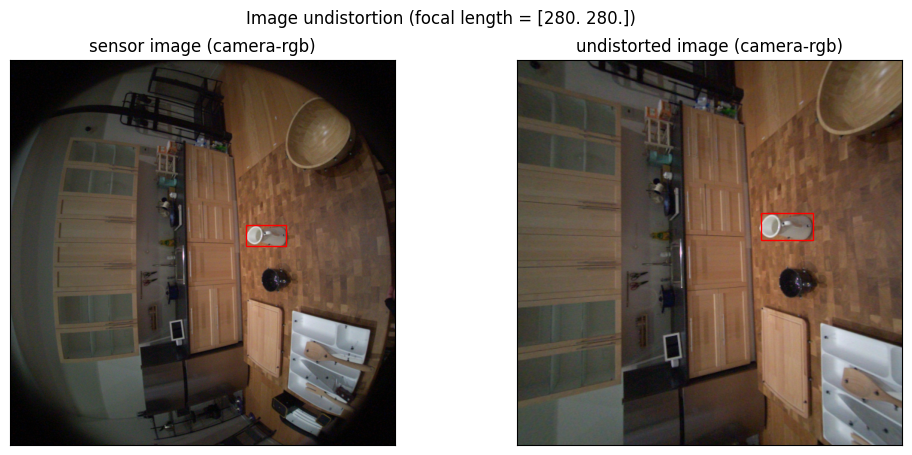

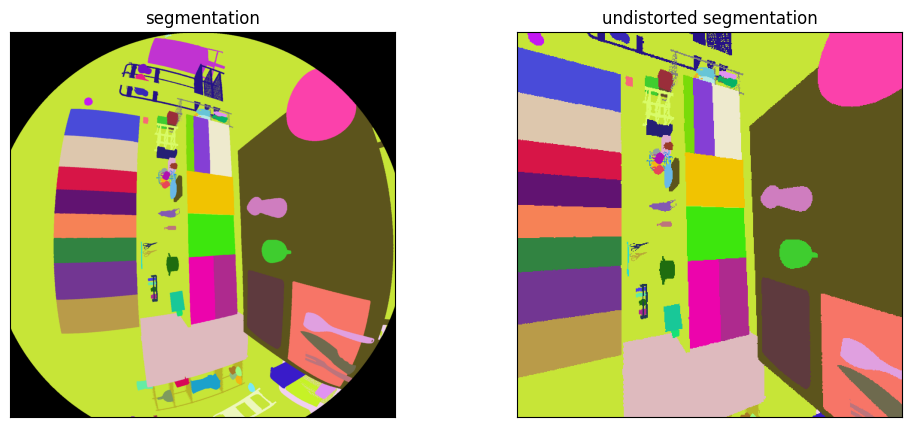

In [17]:
### Rectify the RGB image
# get source calibration - Aria original camera model
sensor_name = gt_provider.raw_data_provider_ptr().get_label_from_stream_id(stream_id)
device_calib = gt_provider.raw_data_provider_ptr().get_device_calibration()
src_calib = device_calib.get_camera_calib(sensor_name)

# create output calibration: a pinhole rectified image size 512x512 and focal length 280
dst_calib = calibration.get_linear_camera_calibration(512, 512, 280, sensor_name)

# rectify image
rectified_image = calibration.distort_by_calibration(image, dst_calib, src_calib)

# visualize input and results
plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Image undistortion (focal length = {dst_calib.get_focal_lengths()})") 
axes[0].imshow(image)
axes[0].title.set_text(f"sensor image ({sensor_name})"); 
axes[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
axes[1].imshow(rectified_image)
axes[1].title.set_text(f"undistorted image ({sensor_name})")
axes[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

### Rectify 2D bbox 
# get bbox    
bbox2d_target_obj = bbox2d_all_objects[target_obj_id].box_range
bbox2d_draw = patches.Rectangle((bbox2d_target_obj[0], bbox2d_target_obj[2]), 
                                 bbox2d_target_obj[1] - bbox2d_target_obj[0], 
                                 bbox2d_target_obj[3] - bbox2d_target_obj[2], 
                                 linewidth=1, edgecolor='r', facecolor="none")
bbox2d_coords = bbox2d_to_image_coordinates(bbox2d_target_obj)
rect_bbox2d_xs = []
rect_bbox2d_ys = []
for bbox2d_coord in bbox2d_coords:
    unprojected_bbox2d_ray = src_calib.unproject_no_checks(bbox2d_coord)
    rect_bbox2d_coord = dst_calib.project(unprojected_bbox2d_ray)
    rect_bbox2d_xs.append(rect_bbox2d_coord[0])
    rect_bbox2d_ys.append(rect_bbox2d_coord[1])    
rect_bbox2d = [min(rect_bbox2d_xs), max(rect_bbox2d_xs), min(rect_bbox2d_ys), max(rect_bbox2d_ys)]
rect_bbox2d_draw = patches.Rectangle((rect_bbox2d[0], rect_bbox2d[2]), 
                                      rect_bbox2d[1] - rect_bbox2d[0], 
                                      rect_bbox2d[3] - rect_bbox2d[2], 
                                      linewidth=1, edgecolor='r', facecolor="none")

# visualize original 2D bbox and rectified 2D bbox
axes[0].add_patch(bbox2d_draw)
axes[1].add_patch(rect_bbox2d_draw)

### Rectify segmentation image
rectified_segmentation_for_viz = calibration.distort_label_by_calibration(segmentation_for_viz, dst_calib, src_calib)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(segmentation_for_viz)
axes[0].title.set_text("segmentation")
axes[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
axes[1].imshow(rectified_segmentation_for_viz)
axes[1].title.set_text("undistorted segmentation")
axes[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)